In [1]:
%matplotlib notebook
%load_ext autoreload
%pwd

'/ocean/projects/asc170022p/mtragoza/lung-project/notebooks'

In [8]:
import sys, os
import numpy as np
import torch
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt

torch.cuda.is_available()

True

In [9]:
fix_nii_file = '../data/yangfan/valid_100_a_1_preProcessed_lungMask.nii'
mov_nii_file = '../data/yangfan/Patient_0111262324_Study_CT_CHEST_WITHOUT_CONTRAST_42526394_Series_2_DR_30_0.625_Reg_mask.nii.gz'

Loading ../data/yangfan/valid_100_a_1_preProcessed_lungMask.nii...
(512, 512, 349)
(0.7890625, 0.7890625, 1.0)


<IPython.core.display.Javascript object>


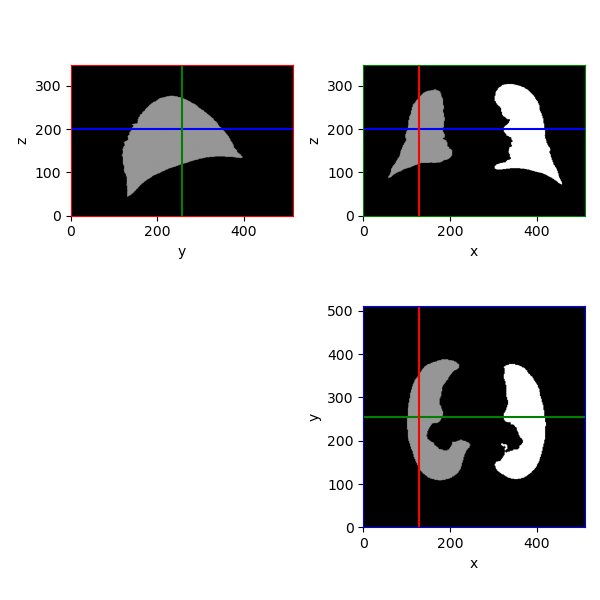

In [53]:
def load_nii_file(nii_file):
    print(f'Loading {nii_file}...')
    nifti = nib.load(nii_file)
    print(nifti.header.get_data_shape())
    print(nifti.header.get_zooms())
    return nifti

def view_image_3d(im, index, **kwargs):
    nx, ny, nz = im.shape
    ix, iy, iz = index
    
    fig, ax = plt.subplots(2, 2, figsize=(6, 6))
    
    ax[0,0].imshow(im[ix,:,:].T, **kwargs)
    ax[0,0].set_xlabel('y')
    ax[0,0].set_ylabel('z')
    ax[0,0].hlines(iz, 0, ny, 'b')
    ax[0,0].vlines(iy, 0, nz, 'g')
    ax[0,0].set_xlim(0, ny)
    ax[0,0].set_ylim(0, nz)
    plt.setp(ax[0,0].spines.values(), color='r')
    
    ax[0,1].imshow(im[:,iy,:].T, **kwargs)
    ax[0,1].set_xlabel('x')
    ax[0,1].set_ylabel('z')
    ax[0,1].hlines(iz, 0, nx, 'b')
    ax[0,1].vlines(ix, 0, nz, 'r')
    ax[0,1].set_xlim(0, nx)
    ax[0,1].set_ylim(0, nz)
    plt.setp(ax[0,1].spines.values(), color='g')
    
    ax[1,1].imshow(im[:,:,iz].T, **kwargs)
    ax[1,1].set_xlabel('x')
    ax[1,1].set_ylabel('y')
    ax[1,1].hlines(iy, 0, nx, 'g')
    ax[1,1].vlines(ix, 0, ny, 'r')
    ax[1,1].set_xlim(0, nx)
    ax[1,1].set_ylim(0, ny)
    plt.setp(ax[1,1].spines.values(), color='b')
    
    ax[1,0].axis('off')
    
    fig.tight_layout()

fix_nifti = load_nii_file(fix_nii_file)
fix_fdata = fix_nifti.get_fdata()[:,::-1].copy()
view_image_3d(fix_fdata, index=(128,256,200), cmap='Greys_r', vmin=0, vmax=2)

Loading ../data/yangfan/Patient_0111262324_Study_CT_CHEST_WITHOUT_CONTRAST_42526394_Series_2_DR_30_0.625_Reg_mask.nii.gz...
(316, 316, 292)
(1.0, 1.0, 1.0)


<IPython.core.display.Javascript object>


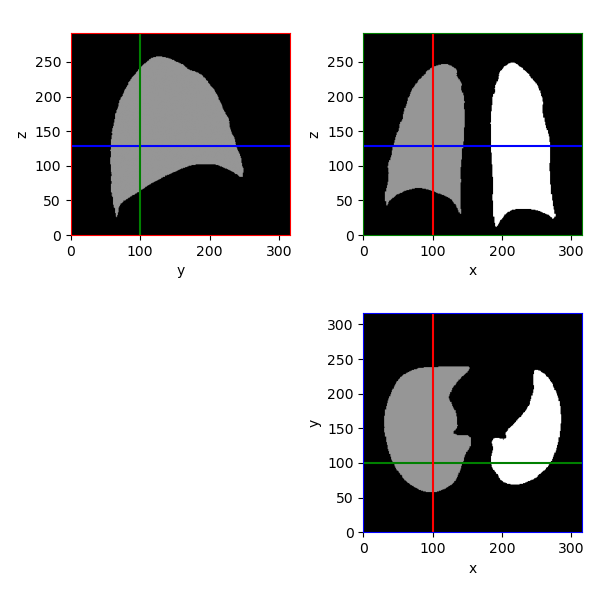

In [54]:
mov_nifti = load_nii_file(mov_nii_file)
mov_fdata = mov_nifti.get_fdata()
view_image_3d(mov_fdata, index=(100,100,128), cmap='Greys_r', vmin=0, vmax=100)

In [55]:
sys.path.append('../../Lung250M-4B')
import corrfield

In [56]:
%%time

img_mov = torch.as_tensor(mov_fdata, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda()
img_fix = torch.as_tensor(fix_fdata, dtype=torch.float).unsqueeze(0).unsqueeze(0).cuda()

img_mov = F.interpolate(img_mov, size=(256, 256, 128))
img_fix = F.interpolate(img_fix, size=(256, 256, 128))
print(img_mov.shape)
print(img_fix.shape)

mask_fix = torch.ones_like(img_fix)

disp, _, _ = corrfield.corrfield.corrfield(
    img_mov=img_mov,
    img_fix=img_fix,
    mask_fix=mask_fix,
    T=['r', 'r']
)
disp.shape

torch.Size([1, 1, 256, 256, 128])
torch.Size([1, 1, 256, 256, 128])
Compute fixed MIND features ... 

/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../Lung250M-4B/corrfield/mindssc.py:52: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  F.conv3d(rpad(img), mshift1, dilation=delta) -


finished (18.26 s).
Stage 1/2
    search radius: 16
      cube length: 6
     quantisation: 2
     patch radius: 3
        transform: r
    Compute moving MIND features ... finished (0.05 s).
    885 fixed keypoints extracted (0.10 s).
    Compute forward marginals ... 

/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/../../Lung250M-4B/corrfield/graphs.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/torch/csrc/utils/tensor_new.cpp:274.)
  edges = torch.tensor(


finished (0.94 s).
    Compute symmetric backward marginals ... finished (0.67 s).
    Find rigid transform ... finished (8.14 s).

Stage 2/2
    search radius: 8
      cube length: 3
     quantisation: 1
     patch radius: 2
        transform: r
    Compute moving MIND features ... finished (0.05 s).
    1678 fixed keypoints extracted (0.05 s).
    Compute forward marginals ... finished (0.46 s).
    Compute symmetric backward marginals ... finished (0.45 s).
    Find rigid transform ... finished (0.01 s).

CPU times: user 6.26 s, sys: 699 ms, total: 6.96 s
Wall time: 29.9 s


torch.Size([1, 256, 256, 128, 3])

In [57]:
_, _, D, H, W = img_fix.shape
disp_pt = corrfield.utils.flow_pt(disp, shape=(D, H, W), align_corners=True)
disp_pt.shape

torch.Size([1, 256, 256, 128, 3])

In [58]:
img_mov_warped = F.grid_sample(
    img_mov,
    F.affine_grid(
        torch.eye(3, 4, dtype=img_mov.dtype, device='cuda').unsqueeze(0),
        (1, 1, D, H, W),
        align_corners=True
    ) + disp_pt,
    align_corners=True
)
img_mov_warped.shape

torch.Size([1, 1, 256, 256, 128])

In [59]:
img_mov = img_mov[0,0].detach().cpu().numpy()
img_fix = img_fix[0,0].detach().cpu().numpy()
img_mov_warped = img_mov_warped[0,0].detach().cpu().numpy()
disp = disp[0].detach().cpu().numpy()

img_fix.shape, img_mov.shape, img_mov_warped.shape, disp.shape

((256, 256, 128), (256, 256, 128), (256, 256, 128), (256, 256, 128, 3))

<IPython.core.display.Javascript object>


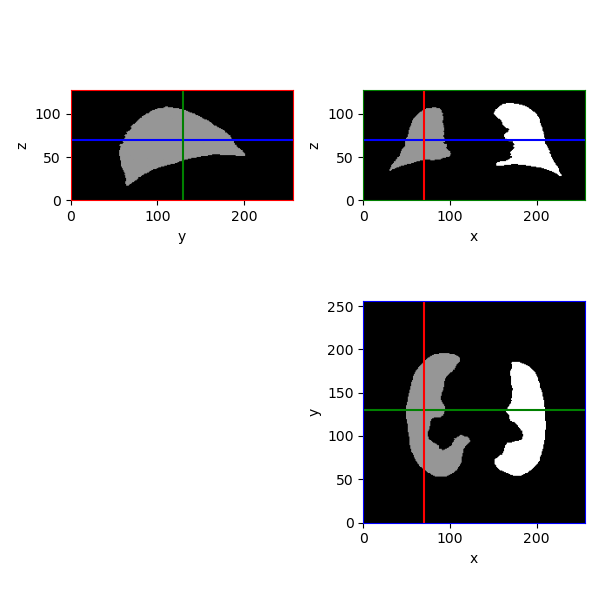

In [74]:
view_image_3d(img_fix, index=(70,130,70), cmap='Greys_r', vmin=0, vmax=2)

<IPython.core.display.Javascript object>


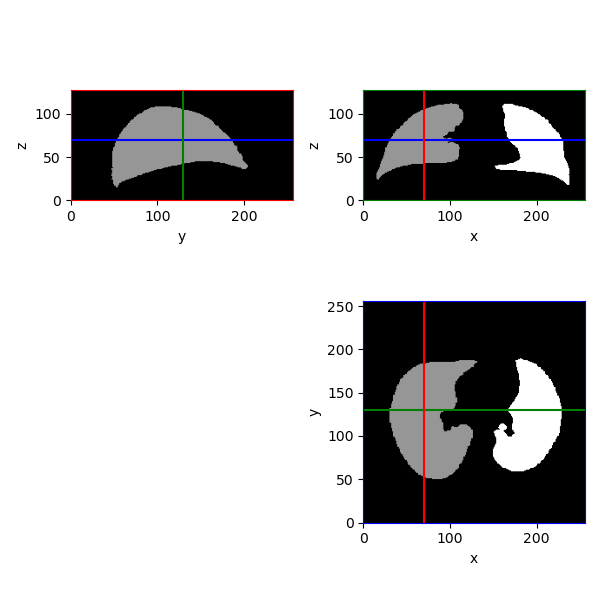

In [76]:
view_image_3d(img_mov, index=(70,130,70), cmap='Greys_r', vmin=0, vmax=100)

<IPython.core.display.Javascript object>


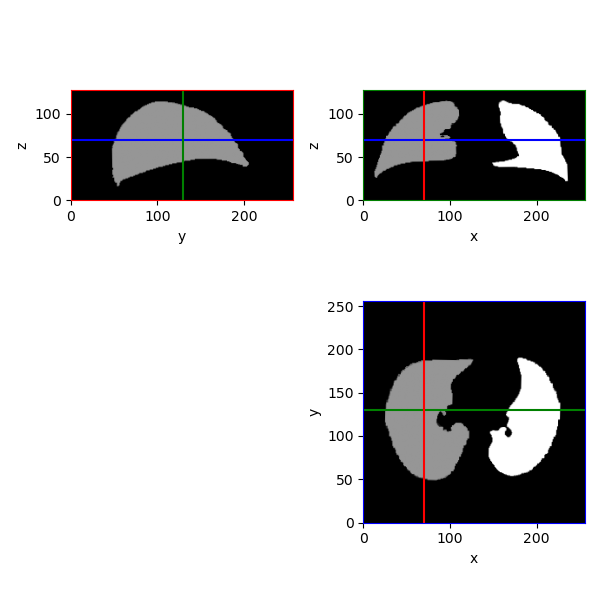

In [78]:
view_image_3d(img_mov_warped, index=(70,130,70), cmap='Greys_r', vmin=0, vmax=100)

<IPython.core.display.Javascript object>


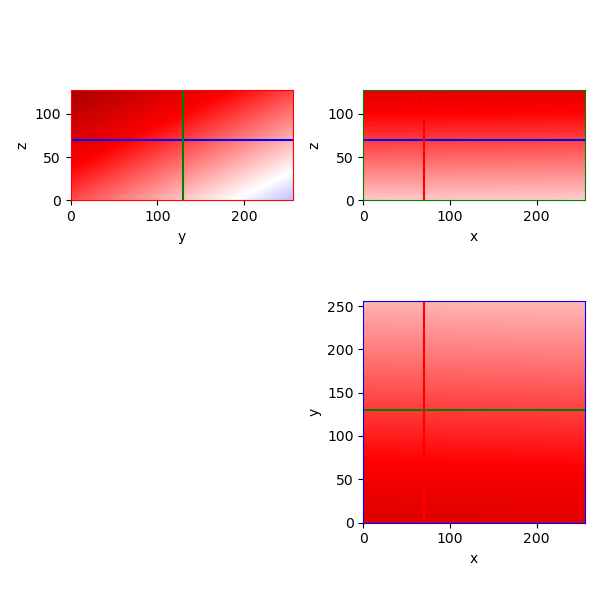

<IPython.core.display.Javascript object>


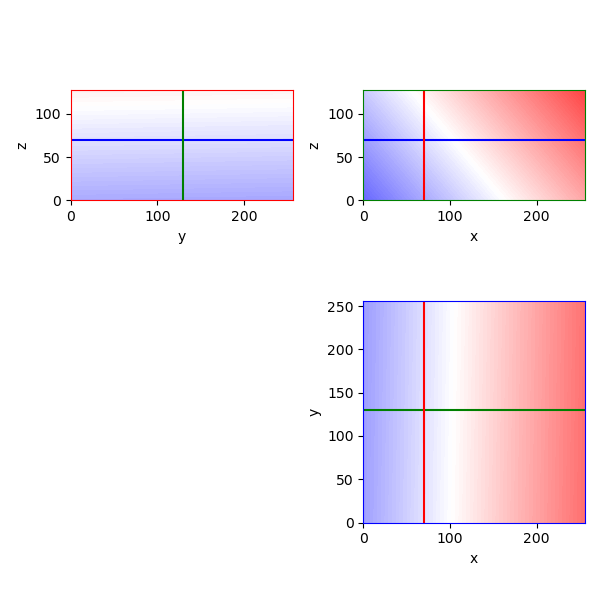

<IPython.core.display.Javascript object>


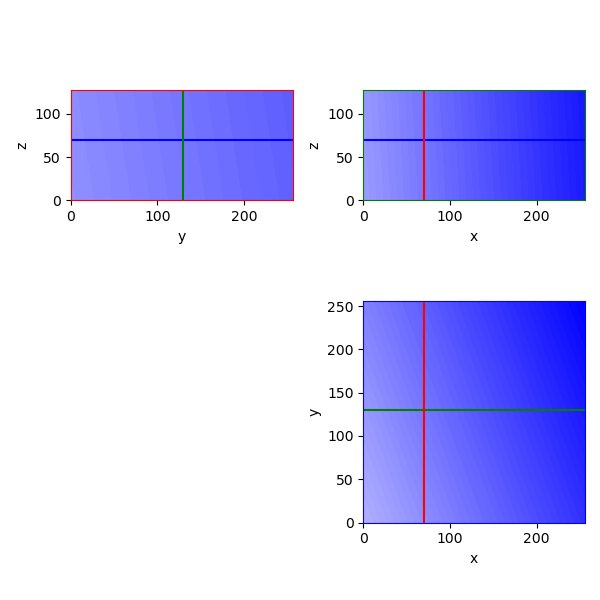

In [85]:
view_image_3d(disp[...,0], index=(70,130,70), cmap='seismic', vmin=-10, vmax=10)
view_image_3d(disp[...,1], index=(70,130,70), cmap='seismic', vmin=-10, vmax=10)
view_image_3d(disp[...,2], index=(70,130,70), cmap='seismic', vmin=-10, vmax=10)